In [114]:
# Imports
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from pyspark.sql import SparkSession, functions as F
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor


In [115]:
# Utility: save all current matplotlib figures to a folder
from pathlib import Path

def save_all_figures(out_dir="plots", prefix="fig", dpi=300, close=False):
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)
    saved = []
    for idx, num in enumerate(plt.get_fignums(), start=1):
        fig = plt.figure(num)
        title = fig._suptitle.get_text() if fig._suptitle else ""
        safe_title = "".join(c if c.isalnum() or c in "-_" else "_" for c in title).strip("_")
        name = f"{prefix}_{idx:02d}"
        print(name, title)
        if safe_title:
            name += f"_{safe_title[:40]}"
        filepath = out_path / f"{name}.png"
        fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
        saved.append(filepath)
    if close:
        plt.close('all')
    print(f"Saved {len(saved)} figure(s) to {out_path}")
    return saved


In [116]:
print(plt.get_fignums())

[]


In [117]:
# PART 1: Spark aggregation to state-year (weighted rates/means)

BASE = "/Users/compiling/435Project/Project"
COMPLETE_DIR = Path(BASE) / "complete"

spark = SparkSession.builder.appName("P").getOrCreate()

micro = spark.read.parquet(str(COMPLETE_DIR / "pums_*.parquet"))
print("Total micro rows (all years):", micro.count())

weight_col = 'PWGTP'
group_cols = ['STATE_NAME', 'YEAR']
wt_sum = F.sum(weight_col)

features = [
    wt_sum.alias('state_year_population'),
    F.first('TOTAL_HEALTH_SPENDING').alias('TOTAL_HEALTH_SPENDING'),

    # Demographics
    (F.sum(F.when(F.col('AGEP') >= 65, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_65plus_share'),
    (F.sum(F.when(F.col('AGEP') <= 17, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_0_17_share'),
    (F.sum(F.when(F.col('SEX') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SEX_female_share'),
    (F.sum(F.when(F.col('MAR').isin(1, 2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MAR_ever_married_share'),

    # Health insurance coverage
    (F.sum(F.when(F.col('HICOV') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HICOV_uninsured_share'),
    (F.sum(F.when(F.col('HINS1') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS1_employer_share'),
    (F.sum(F.when(F.col('HINS2') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS2_direct_share'),
    (F.sum(F.when(F.col('HINS3') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS3_medicare_share'),
    (F.sum(F.when(F.col('HINS4') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS4_medicaid_share'),
    (F.sum(F.when(F.col('HINS5') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS5_tricare_share'),
    (F.sum(F.when(F.col('HINS6') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS6_va_share'),

    # Economic & income
    (F.sum(F.when(F.col('POVPIP') < 138, F.col(weight_col)).otherwise(0)) / wt_sum).alias('POVPIP_lt138_share'),
    (F.sum(F.col('PINCP') * F.col(weight_col)) / wt_sum).alias('PINCP_mean'),
    (F.sum(F.col('WAGP') * F.col(weight_col)) / wt_sum).alias('WAGP_mean'),
    (F.sum(F.col('SEMP') * F.col(weight_col)) / F.sum(F.when(F.col('SEMP') > 0, F.col(weight_col)).otherwise(None))).alias('SEMP_mean_if_positive'),
    (F.sum(F.col('SSP') * F.col(weight_col)) / wt_sum).alias('SSP_per_capita'),
    (F.sum(F.when(F.col('RETP') > 0, F.col(weight_col)).otherwise(0)) / wt_sum).alias('RETP_positive_share'),

    # Employment & labor
    (F.sum(F.when(F.col('ESR').isin(3, 6), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_unemp_or_nilf_share'),
    (F.sum(F.when(F.col('ESR').isin(1, 2, 3, 4, 5), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_in_labor_force_share'),

    # Education & social
    (F.sum(F.when(F.col('SCHL') >= 21, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SCHL_bach_plus_share'),
    (F.sum(F.when(F.col('DOUT') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DOUT_diff_share'),
    (F.sum(F.when(F.col('DPHY') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DPHY_diff_share'),
    (F.sum(F.when(F.col('DIS') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DIS_any_share'),
    (
        1000.0
        * F.sum(
            F.when(
                (F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)) & (F.col('FER') == 1),
                F.col(weight_col),
            ).otherwise(0)
        )
        / F.sum(F.when((F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)), F.col(weight_col)).otherwise(None))
    ).alias('FER_births_per_1000_women_15_50'),

    # Access & lifestyle
    (F.sum(F.when(F.col('BROADBND') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('BROADBND_yes_share'),
    (F.sum(F.col('VEH') * F.col(weight_col)) / wt_sum).alias('VEH_mean_per_person'),
    (F.sum(F.when(F.col('MIL').isin(2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_veteran_share'),
    (F.sum(F.when(F.col('MIL') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_active_duty_share'),
]

print("Aggregating microdata to state-year panel ...")
df_state_year = (
    micro
    .groupBy(*group_cols)
    .agg(*features)
    .toPandas()
)
print('Final panel shape:', df_state_year.shape)
df_state_year.head()


Total micro rows (all years): 15912393


25/12/06 21:59:06 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /Users/compiling/435Project/Project/complete/pums_*.parquet.
java.io.FileNotFoundException: File /Users/compiling/435Project/Project/complete/pums_*.parquet does not exist
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileStatus(RawLocalFileSystem.java:917)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:1238)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileStatus(RawLocalFileSystem.java:907)
	at org.apache.hadoop.fs.FilterFileSystem.getFileStatus(FilterFileSystem.java:462)
	at org.apache.spark.sql.execution.streaming.FileStreamSink$.hasMetadata(FileStreamSink.scala:56)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:381)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(Resol

Aggregating microdata to state-year panel ...


Final panel shape: (255, 32)


,STATE_NAME,YEAR,state_year_population,TOTAL_HEALTH_SPENDING,AGEP_65plus_share,AGEP_0_17_share,SEX_female_share,MAR_ever_married_share,HICOV_uninsured_share,HINS1_employer_share,...,ESR_in_labor_force_share,SCHL_bach_plus_share,DOUT_diff_share,DPHY_diff_share,DIS_any_share,FER_births_per_1000_women_15_50,BROADBND_yes_share,VEH_mean_per_person,MIL_veteran_share,MIL_active_duty_share
0,Georgia,2023,11029227,7984.0,0.153987,0.229787,0.512272,0.510425,0.118536,0.522321,...,0.513037,0.249936,0.048654,0.066701,0.138376,50.980524,0.882308,2.146883,0.063762,0.005160
1,New Jersey,2023,9290841,9676.0,0.177698,0.216073,0.507687,0.521444,0.071422,0.598993,...,0.541512,0.326099,0.045048,0.054495,0.112192,51.128098,0.902386,1.919621,0.034651,0.000931
2,Minnesota,2021,5707390,8686.0,0.168798,0.228722,0.499954,0.533945,0.043775,0.609255,...,0.547687,0.277308,0.047489,0.050248,0.124941,56.288797,0.875737,2.168501,0.059511,0.000425
3,Kansas,2023,2940547,8502.0,0.176232,0.233088,0.497563,0.549769,0.083518,0.573489,...,0.526105,0.253048,0.050902,0.065071,0.146462,55.325867,0.865346,2.234180,0.061661,0.008434
4,Utah,2021,3337975,5734.0,0.116340,0.282819,0.492425,0.517114,0.093118,0.633758,...,0.516075,0.227447,0.034616,0.040597,0.106772,59.919620,0.897629,2.513679,0.044944,0.002226


In [118]:

# PART 2: Pooled RF model (per-capita target, log1p transform, shuffled split 70/20/10 + simple val-based tuning)

# Verify target uniqueness per state-year
leakage_counts = df_state_year.groupby(['STATE_NAME', 'YEAR'])['TOTAL_HEALTH_SPENDING'].nunique()
print('Target nunique per state-year:')
print(leakage_counts.value_counts().sort_index())
print('Summary:')
print(leakage_counts.describe())

target = 'TOTAL_HEALTH_SPENDING'  # per-capita dollars
categorical_cols = []  # drop STATE_NAME for pooled drivers
drop_from_X = {
    target, 'STATE_NAME', 'ST', 'state_year_population',
    'SSP_per_capita', 'RETP_positive_share',
    'DOUT_diff_share', 'DPHY_diff_share',
    'YEAR',
}
numeric_cols = [c for c in df_state_year.columns if c not in drop_from_X]

X_full = df_state_year[categorical_cols + numeric_cols]
y_full = np.log1p(df_state_year[target])  # log transform to reduce heteroskedasticity

# 70/20/10 split
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X_full, y_full, test_size=0.10, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.20, random_state=42, shuffle=True
)
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

preprocess = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
])

def eval_split(name, y_true_log, y_pred_log):
    # Invert log for reporting in original units
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> R^2: {r2:,.3f} | MAE: {mae:,.2f} | RMSE: {rmse:,.2f}")
    return r2, mae, rmse

# Hyperparameter grid
from itertools import product
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [10, 15],
    'min_samples_leaf': [1, 2],
}
results = []
best_rmse = None
best_pipe = None
best_params = None
for n_est, depth, leaf in product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['min_samples_leaf']):
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        min_samples_leaf=leaf,
        n_jobs=-1,
        random_state=42,
    )
    pipe_candidate = Pipeline([('pre', preprocess), ('rf', rf)])
    pipe_candidate.fit(X_train, y_train)
    val_pred = pipe_candidate.predict(X_val)
    r2, mae, rmse = eval_split(f'Val (n={n_est}, depth={depth}, leaf={leaf})', y_val, val_pred)
    results.append((rmse, n_est, depth, leaf, r2, mae))
    if best_rmse is None or rmse < best_rmse:
        best_rmse = rmse
        best_pipe = pipe_candidate
        best_params = {'n_estimators': n_est, 'max_depth': depth, 'min_samples_leaf': leaf}

print('Best params (val RMSE):', best_params)
print(f"Best val RMSE: {best_rmse:,.2f}")

# Refit best model on train+val, evaluate on test
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
best_pipe.fit(X_trainval, y_trainval)
y_pred = best_pipe.predict(X_test)
test_r2, test_mae, test_rmse = eval_split('Test (best model)', y_test, y_pred)

# Use best_pipe and y_pred downstream
pipe = best_pipe


Target nunique per state-year:
TOTAL_HEALTH_SPENDING
1    255
Name: count, dtype: int64
Summary:
count    255.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: TOTAL_HEALTH_SPENDING, dtype: float64
Train: 183, Val: 46, Test: 26
Val (n=300, depth=10, leaf=1) -> R^2: 0.620 | MAE: 636.60 | RMSE: 817.14
Val (n=300, depth=10, leaf=2) -> R^2: 0.609 | MAE: 644.13 | RMSE: 828.87
Val (n=300, depth=15, leaf=1) -> R^2: 0.619 | MAE: 637.35 | RMSE: 817.22
Val (n=300, depth=15, leaf=2) -> R^2: 0.606 | MAE: 647.17 | RMSE: 831.09
Val (n=500, depth=10, leaf=1) -> R^2: 0.628 | MAE: 629.74 | RMSE: 808.19
Val (n=500, depth=10, leaf=2) -> R^2: 0.614 | MAE: 639.42 | RMSE: 823.44
Val (n=500, depth=15, leaf=1) -> R^2: 0.629 | MAE: 630.35 | RMSE: 806.64
Val (n=500, depth=15, leaf=2) -> R^2: 0.613 | MAE: 640.78 | RMSE: 824.34
Best params (val RMSE): {'n_estimators': 500, 'max_depth': 15, 'min_samples_leaf': 1}
Best val RMSE: 806.64
Test (best model)

In [119]:

# Permutation importances on validation set (robust to feature correlations)
from sklearn.inspection import permutation_importance
perm = permutation_importance(
pipe, X_val, y_val,
scoring='r2', n_repeats=20, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
'feature': numeric_cols,
'importance': perm.importances_mean,
'std': perm.importances_std,
}).sort_values('importance', ascending=False)
print('Top 15 permutation importances (val):')
print(perm_df.head(15).to_string(index=False))


Top 15 permutation importances (val):
                 feature  importance      std
   HICOV_uninsured_share    0.265062 0.059336
              PINCP_mean    0.141110 0.035050
     VEH_mean_per_person    0.070973 0.013941
          HINS6_va_share    0.054365 0.032958
       AGEP_65plus_share    0.046399 0.006717
    HINS4_medicaid_share    0.044232 0.011521
         AGEP_0_17_share    0.042612 0.007663
    HINS3_medicare_share    0.036180 0.004785
   SEMP_mean_if_positive    0.029942 0.009931
      BROADBND_yes_share    0.025484 0.004238
      HINS2_direct_share    0.024940 0.006553
ESR_in_labor_force_share    0.023868 0.005012
           DIS_any_share    0.022426 0.002574
        SEX_female_share    0.020266 0.004771
    HINS1_employer_share    0.014843 0.003174


In [120]:

# SHAP values for tuned RF (directional feature effects)
import shap
rf_model = pipe.named_steps['rf'] if hasattr(pipe, 'named_steps') else None
preproc = pipe.named_steps['pre'] if hasattr(pipe, 'named_steps') else None
if rf_model is None or preproc is None:
    print('Pipeline missing expected steps (pre, rf).')
else:
    X_val_trans = preproc.transform(X_val)
    explainer = shap.TreeExplainer(rf_model)
    shap_vals = explainer.shap_values(X_val_trans)
    print('SHAP summary plot (val set):')
    shap.summary_plot(shap_vals, X_val_trans, feature_names=numeric_cols, show=False)
    out_dir = Path("plots")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "shap_summary.png"
    fig = plt.gcf()
    fig.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"Saved {out_path}")
    plt.close(fig)


SHAP summary plot (val set):
Saved plots/shap_summary.png


In [121]:

# Bootstrap 95% CI for test metrics (MAE/RMSE/R²)
from sklearn.utils import resample


n_boot = 1000
metrics = {'r2': [], 'mae': [], 'rmse': []}
for _ in range(n_boot):
    idx = resample(range(len(y_test)), replace=True, n_samples=len(y_test), random_state=None)
    yt = np.array(y_test)[idx]
    yp = np.array(y_pred)[idx]
    metrics['r2'].append(r2_score(yt, yp))
    metrics['mae'].append(mean_absolute_error(yt, yp))
    metrics['rmse'].append(root_mean_squared_error(yt, yp))
def ci(arr):
    lo, hi = np.percentile(arr, [2.5, 97.5])
    return np.mean(arr), lo, hi
    for name in ['r2', 'mae', 'rmse']:
        mean, lo, hi = ci(metrics[name])
    unit = ' (per-capita $)' if name in ['mae', 'rmse'] else ''
    print(f"Test {name.upper()}{unit}: mean={mean:.3f} CI95% [{lo:.3f}, {hi:.3f}]")


In [122]:
# 5-fold cross-validation on pooled RF pipeline (full data)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'r2': 'r2',
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
}
cv_res = cross_validate(
    pipe, X_full, y_full, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)
mean_r2 = cv_res['test_r2'].mean()
std_r2 = cv_res['test_r2'].std()
mean_mae = (-cv_res['test_mae']).mean()
mean_rmse = (-cv_res['test_rmse']).mean()
print(f"5-fold CV -> R^2: {mean_r2:.3f} +/- {std_r2:.3f} | MAE: {mean_mae:,.2f} | RMSE: {mean_rmse:,.2f}")

5-fold CV -> R^2: 0.721 +/- 0.041 | MAE: 0.07 | RMSE: 0.09


Saved plots/residual_histograms.png


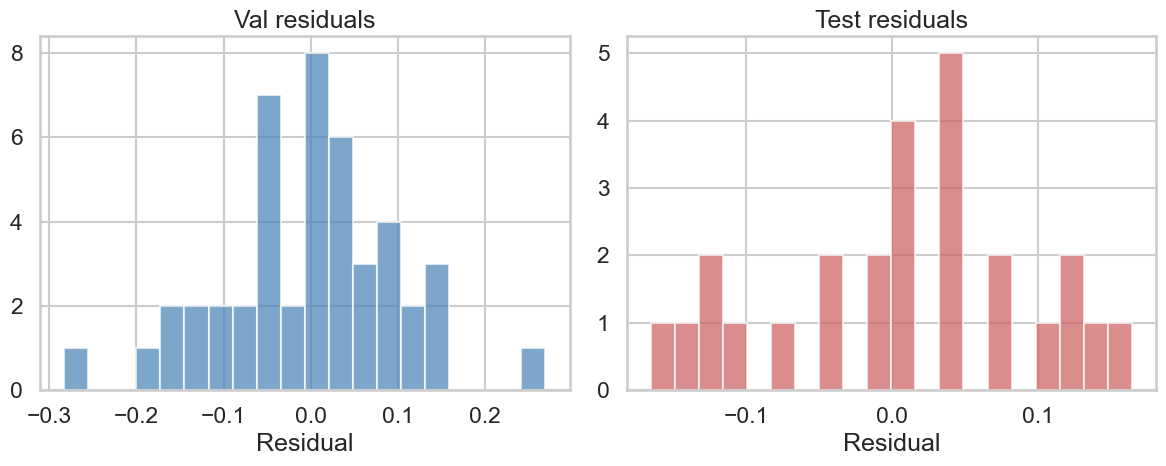

Saved plots/residual_vs_fitted.png


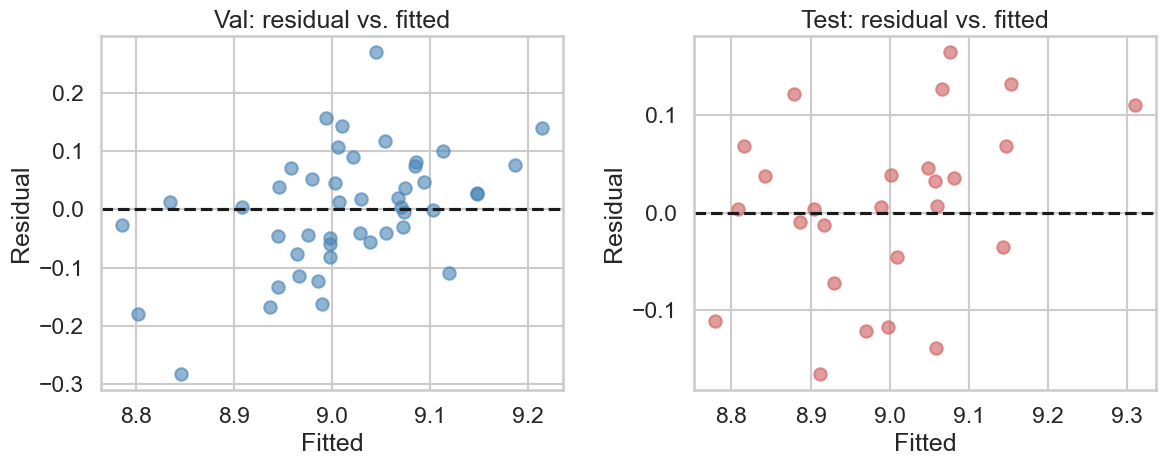

In [123]:
# Residuals
val_resid = y_val - val_pred
test_resid = y_test - y_pred
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(val_resid, bins=20, alpha=0.7, color='steelblue')
axes[0].set_title('Val residuals')
axes[0].set_xlabel('Residual')
axes[1].hist(test_resid, bins=20, alpha=0.7, color='indianred')
axes[1].set_title('Test residuals')
axes[1].set_xlabel('Residual')
plt.tight_layout()
out_dir = Path("plots")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "residual_histograms.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved {out_path}")
plt.show()

# Residual vs. fitted
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(val_pred, val_resid, alpha=0.6, color='steelblue')
axes[0].axhline(0, color='k', linestyle='--')
axes[0].set_title('Val: residual vs. fitted')
axes[0].set_xlabel('Fitted')
axes[0].set_ylabel('Residual')

axes[1].scatter(y_pred, test_resid, alpha=0.6, color='indianred')
axes[1].axhline(0, color='k', linestyle='--')
axes[1].set_title('Test: residual vs. fitted')
axes[1].set_xlabel('Fitted')
axes[1].set_ylabel('Residual')
plt.tight_layout()
out_path2 = out_dir / "residual_vs_fitted.png"
plt.savefig(out_path2, dpi=300, bbox_inches='tight')
print(f"Saved {out_path2}")
plt.show()


Saved plots/baseline_rf_scatter.png


/var/folders/zy/dcp74d8d6rn7pyyg_ghpdb700000gn/T/ipykernel_40890/521789485.py:9: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



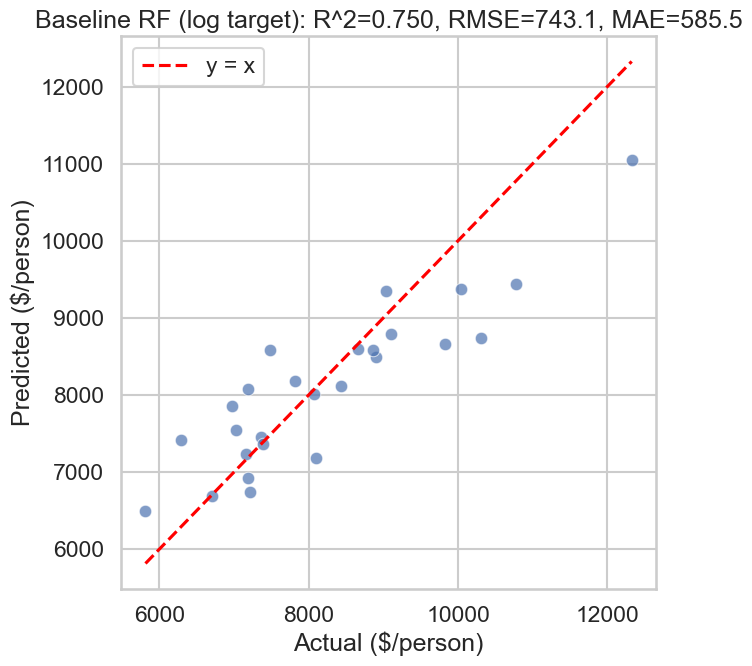

In [124]:

# Baseline RF scatter (test set, log1p target inverted to dollars)
sns.set_theme(style="whitegrid", context="talk")
y_test_d = np.expm1(np.array(y_test))
y_pred_d = np.expm1(np.array(y_pred))
rmse = root_mean_squared_error(y_test_d, y_pred_d)
mae = mean_absolute_error(y_test_d, y_pred_d)
r2 = r2_score(y_test_d, y_pred_d)
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test_d, y=y_pred_d, palette='Blues', alpha=0.7)
lo, hi = min(y_test_d.min(), y_pred_d.min()), max(y_test_d.max(), y_pred_d.max())
plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual ($/person)')
plt.ylabel('Predicted ($/person)')
plt.title(f'Baseline RF (log target): R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
plt.legend()
plt.tight_layout()
out_dir = Path("plots")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "baseline_rf_scatter.png"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved {out_path}")
plt.show()


In [125]:

# Residual normality (Shapiro-Wilk) and heteroskedasticity (Breusch-Pagan)
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
   
if 'y_pred' not in globals() or 'y_test' not in globals():
    print('Run the RF training cell first to get y_pred and y_test.')
else:
    test_resid = np.array(y_test) - np.array(y_pred)
    stat, p = shapiro(test_resid)
    print(f'Shapiro-Wilk (test residuals): W={stat:.3f}, p={p:.3g}')
y_fitted = np.array(y_pred)
exog = sm.add_constant(y_fitted)
bp_stat, bp_p, _, _ = het_breuschpagan(test_resid, exog)
print(f'Breusch-Pagan (test residuals): stat={bp_stat:.3f}, p={bp_p:.3g}')


Shapiro-Wilk (test residuals): W=0.966, p=0.517
Breusch-Pagan (test residuals): stat=0.614, p=0.433


In [126]:
# PART 2b: Random Forest feature importances

if hasattr(pipe, 'named_steps') and 'rf' in pipe.named_steps:

    rf_model = pipe.named_steps['rf']
    importances = rf_model.feature_importances_
    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': importances,
    }).sort_values('importance', ascending=False)
    print('Top 15 feature importances:')
    print(fi.head(15).to_string(index=False))
else:
    print('RandomForestRegressor not found in pipeline; skipping importances')


Top 15 feature importances:
                 feature  importance
   HICOV_uninsured_share    0.196684
              PINCP_mean    0.171942
          HINS6_va_share    0.063943
     VEH_mean_per_person    0.063773
   SEMP_mean_if_positive    0.055631
        SEX_female_share    0.041600
    HINS4_medicaid_share    0.041184
ESR_in_labor_force_share    0.038942
         AGEP_0_17_share    0.037622
       AGEP_65plus_share    0.033886
      HINS2_direct_share    0.033644
    HINS3_medicare_share    0.028202
 ESR_unemp_or_nilf_share    0.022571
       MIL_veteran_share    0.020428
           DIS_any_share    0.019615


In [127]:
# PART 2c: Top 5 feature importances per year (separate RF per year)

years = sorted(df_state_year['YEAR'].unique())
print('Per-year RF importances (top 5):')

for yr in years:
    df_y = df_state_year[df_state_year['YEAR'] == yr].copy()
    if df_y.shape[0] < 10:
        print(f'Year {yr}: skipped (too few rows: {df_y.shape[0]})')
        continue

    X_y = df_y[numeric_cols]
    y_y = df_y[target]

    rf_y = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        n_jobs=-1,
        random_state=42,
    )
    rf_y.fit(X_y, y_y)

    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': rf_y.feature_importances_,
    }).sort_values('importance', ascending=False).head(5)
    print(f'Year {yr} (rows={len(df_y)}):')
    print(fi.to_string(index=False))
 


Per-year RF importances (top 5):
Year 2019 (rows=51):
                 feature  importance
   HICOV_uninsured_share    0.213377
ESR_in_labor_force_share    0.111528
     VEH_mean_per_person    0.076396
              PINCP_mean    0.067977
         AGEP_0_17_share    0.065045
Year 2020 (rows=51):
                 feature  importance
ESR_in_labor_force_share    0.163820
   HICOV_uninsured_share    0.130297
     VEH_mean_per_person    0.086541
         AGEP_0_17_share    0.073723
              PINCP_mean    0.057114
Year 2021 (rows=51):
              feature  importance
HICOV_uninsured_share    0.194319
           PINCP_mean    0.146662
  VEH_mean_per_person    0.103731
     SEX_female_share    0.057047
 HINS3_medicare_share    0.052989
Year 2022 (rows=51):
              feature  importance
HICOV_uninsured_share    0.220417
SEMP_mean_if_positive    0.135263
  VEH_mean_per_person    0.087579
    AGEP_65plus_share    0.055631
     SEX_female_share    0.047143
Year 2023 (rows=51):
          

In [128]:
# scikit-optimize install (run manually if needed):
# %pip install scikit-optimize


In [129]:

# XGBoost baseline model
X = df_state_year[numeric_cols]
y = df_state_year[target]
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

xgb = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    objective='reg:squarederror',
)

xgb.fit(X_train_x, y_train_x)

for name, yt, yp in [('Train', y_train_x, xgb.predict(X_train_x)), ('Test', y_test_x, xgb.predict(X_test_x))]:
    rmse = root_mean_squared_error(yt, yp)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    print(f"{name} -> RMSE: {rmse:,.2f}  MAE: {mae:,.2f}  R^2: {r2:.3f}")

xgb_baseline_model = xgb
y_pred_xgb = xgb.predict(X_test_x)


Train -> RMSE: 0.17  MAE: 0.13  R^2: 1.000
Test -> RMSE: 674.23  MAE: 563.92  R^2: 0.787


Saved plots/baseline_xgb_scatter.png


/var/folders/zy/dcp74d8d6rn7pyyg_ghpdb700000gn/T/ipykernel_40890/1114783171.py:8: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



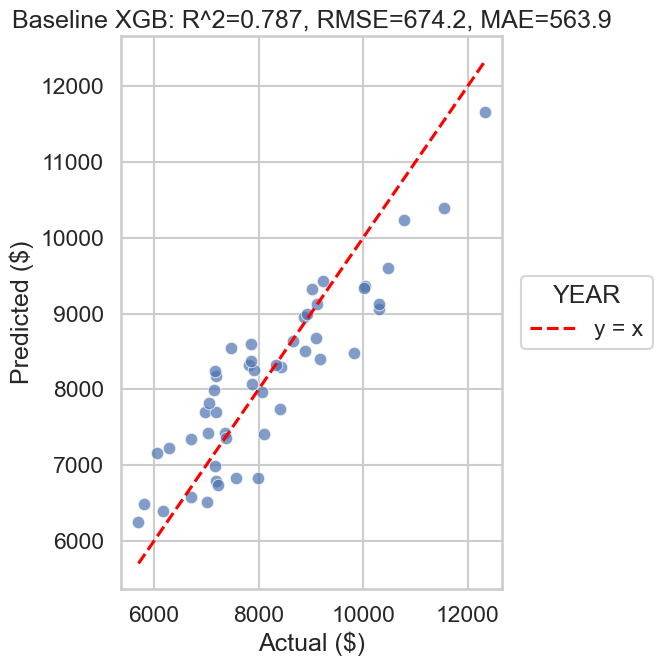

In [130]:
sns.set_theme(style="whitegrid", context="talk")

if 'xgb_baseline_model' in globals():
    rmse = root_mean_squared_error(y_test_x, y_pred_xgb)
    mae = mean_absolute_error(y_test_x, y_pred_xgb)
    r2 = r2_score(y_test_x, y_pred_xgb)
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_test_x, y=y_pred_xgb,
                    hue=X_test_x['YEAR'] if 'YEAR' in X_test_x else None,
                    palette='Blues', alpha=0.7)
    lo, hi = min(y_test_x.min(), y_pred_xgb.min()), max(y_test_x.max(), y_pred_xgb.max())
    plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
    plt.xlabel('Actual ($)')
    plt.ylabel('Predicted ($)')
    plt.title(f'Baseline XGB: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
    plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    out_dir = Path("plots")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / "baseline_xgb_scatter.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f"Saved {out_path}")
    plt.show()
else:
    print('XGB baseline not available in this environment')



In [131]:
top_n = 5

target_col = 'TOTAL_HEALTH_SPENDING'
if 'target' in globals():
    target_col = target

top_feat_by_year = {}

for yr in sorted(df_state_year['YEAR'].unique()):
    df_y = df_state_year[df_state_year['YEAR'] == yr]
    if df_y.shape[0] < 10:
        continue
    X_y = df_y[numeric_cols]
    y_y = df_y[target_col]
    rf_y = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        n_jobs=-1,
        random_state=42,
    )
    rf_y.fit(X_y, y_y)
    s = pd.Series(rf_y.feature_importances_, index=numeric_cols).nlargest(top_n)
    top_feat_by_year[yr] = ', '.join([f"{feat} ({imp:.3f})" for feat, imp in s.items()])
if top_feat_by_year:
    print(f'Computed top {top_n} features for {len(top_feat_by_year)} years.')
else:
    print('No per-year importances computed (too few rows or data issues).')


Computed top 5 features for 5 years.


In [132]:

# Animated choropleth over years (hover shows precomputed top-5 per-year RF features)
metric_col = 'TOTAL_HEALTH_SPENDING'  # change to any numeric column in df_state_year
color_range = None  # optionally set (min, max) for consistent scale across years

target_top_n = globals().get('top_n', 5)
STATE_TO_ABBR = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
}

if 'df_state_year' not in globals() or 'numeric_cols' not in globals():
    print('df_state_year or numeric_cols missing; run the prep cell first.')
elif 'YEAR' not in df_state_year.columns:
    print("Column 'YEAR' missing in df_state_year; cannot animate.")
elif metric_col not in df_state_year.columns:
    print(f"Column {metric_col} not in df_state_year; choose another metric_col.")
else:
    df_plot = df_state_year.copy()
    if 'ST' not in df_plot.columns and 'STATE_NAME' in df_plot.columns:
        df_plot['ST'] = df_plot['STATE_NAME'].map(STATE_TO_ABBR)
    if 'ST' not in df_plot.columns:
        print("Need 'ST' or 'STATE_NAME' to map to state codes before plotting.")
    else:
        df_plot = df_plot.dropna(subset=['ST', metric_col, 'YEAR'])
        if df_plot.empty:
            print('No data after cleaning for ST/metric/YEAR.')
        else:
            if 'top_feat_by_year' in globals():
                df_plot['top_features'] = df_plot['YEAR'].map(top_feat_by_year).fillna('n/a')
            else:
                df_plot['top_features'] = 'n/a (run precompute cell)'

            if color_range is None:
                color_range = (df_plot[metric_col].min(), df_plot[metric_col].max())
            fig = px.choropleth(
                df_plot,
                locations='ST',
                locationmode='USA-states',
                color=metric_col,
                hover_name='STATE_NAME' if 'STATE_NAME' in df_plot.columns else 'ST',
                hover_data={'top_features': True},
                scope='usa',
                color_continuous_scale='Blues',
                animation_frame='YEAR',
                labels={metric_col: metric_col.replace('_', ' '), 'top_features': f'Top {target_top_n} features'},
                range_color=color_range,
                height=550,
            )
            fig.update_layout(title=f"{metric_col.replace('_', ' ')} by state (animated) — hover for top {target_top_n} features")
            fig.update_layout(transition={'duration': 0})
            years_sorted = sorted(df_plot['YEAR'].unique())
            fig.update_layout(
                updatemenus=[{
                    'type': 'buttons',
                    'showactive': True,
                    'x': 1.05,
                    'y': 1.15,
                    'buttons': [
                        {
                            'label': 'Play',
                            'method': 'animate',
                            'args': [None, {
                                'frame': {'duration': 800, 'redraw': True},
                                'transition': {'duration': 0},
                                'fromcurrent': True,
                            }]
                        },
                        {
                            'label': 'Pause',
                            'method': 'animate',
                            'args': [[None], {
                                'frame': {'duration': 0, 'redraw': False},
                                'mode': 'immediate',
                            }]
                        }
                    ]
                }],
                sliders=[{
                    'pad': {'t': 50},
                    'x': 0.1,
                    'len': 0.8,
                    'currentvalue': {'prefix': 'Year: '},
                    'steps': [
                        {
                            'label': str(yr),
                            'method': 'animate',
                            'args': [[str(yr)], {'mode': 'immediate', 'frame': {'duration': 0, 'redraw': True}, 'transition': {'duration': 0}}]
                        }
                        for yr in years_sorted
                    ],
                }]
            )

            out_path = 'choropleth_anim.html'
            fig.write_html(out_path, include_plotlyjs='cdn', full_html=True)
            print(f'Wrote animated choropleth to {out_path}')
            from IPython.display import HTML, display
            display(HTML(fig.to_html(include_plotlyjs='cdn', full_html=False)))


Wrote animated choropleth to choropleth_anim.html


In [133]:
latest_year = df_state_year['YEAR'].max()
df_train_time = df_state_year[df_state_year['YEAR'] < latest_year]
df_test_time = df_state_year[df_state_year['YEAR'] == latest_year]

X_train_time = df_train_time[numeric_cols]
y_train_time = np.log1p(df_train_time[target])
X_test_time = df_test_time[numeric_cols]
y_test_time = np.log1p(df_test_time[target])

pipe_time = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_leaf=best_params['min_samples_leaf'],
        n_jobs=-1,
        random_state=42,
    )),
])

pipe_time.fit(X_train_time, y_train_time)
y_pred_time = pipe_time.predict(X_test_time)

# Evaluate in original units
yt = np.expm1(y_test_time)
yp = np.expm1(y_pred_time)
r2 = r2_score(yt, yp)
mae = mean_absolute_error(yt, yp)
rmse = root_mean_squared_error(yt, yp)
print(f"Time holdout (train ≤ {latest_year-1}, test {latest_year}) -> R^2: {r2:.3f} | MAE: {mae:,.1f} | RMSE: {rmse:,.1f}")
print(f"Test rows: {len(X_test_time)} (year {latest_year})")


Time holdout (train ≤ 2022, test 2023) -> R^2: 0.412 | MAE: 912.2 | RMSE: 1,066.3
Test rows: 51 (year 2023)


Saved plots/yearly_feature_importances.png


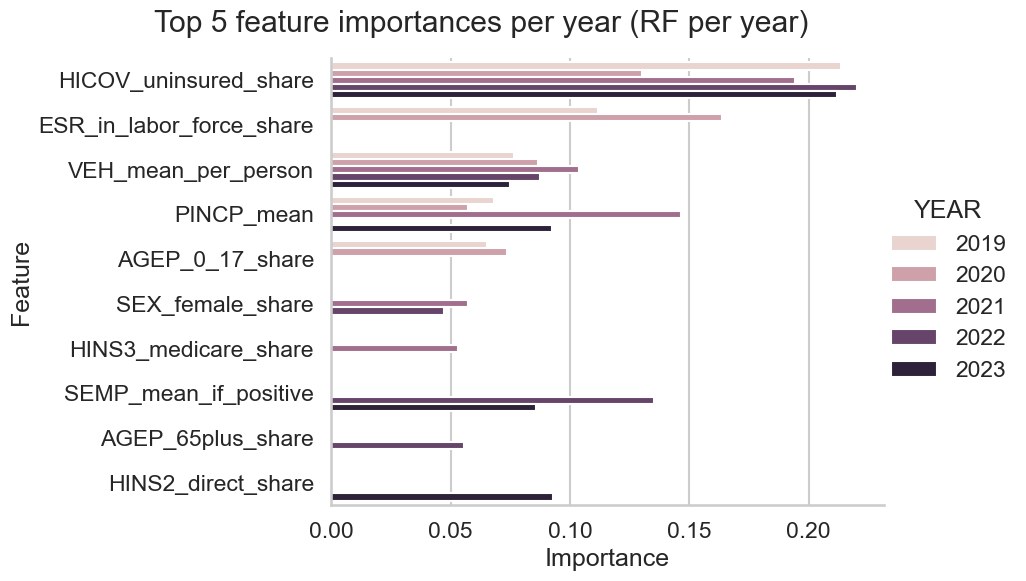

In [134]:
# Plot top feature importances per year (RF per year)
top_n_plot = 5
importance_rows = []

for yr in sorted(df_state_year['YEAR'].unique()):
    df_y = df_state_year[df_state_year['YEAR'] == yr]
    if df_y.shape[0] < 10:
        continue
    X_y = df_y[numeric_cols]
    y_y = df_y[target_col]
    rf_y = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        n_jobs=-1,
        random_state=42,
    )
    rf_y.fit(X_y, y_y)
    s = pd.Series(rf_y.feature_importances_, index=numeric_cols).nlargest(top_n_plot)
    for feat, imp in s.items():
        importance_rows.append({'YEAR': yr, 'feature': feat, 'importance': imp})

if not importance_rows:
    print('No per-year importances to plot (too few rows or data issues).')
else:
    imp_df = pd.DataFrame(importance_rows)
    g = sns.catplot(
        data=imp_df,
        kind='bar',
        x='importance', y='feature', hue='YEAR',
        height=6, aspect=1.6,
    )
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Top {top_n_plot} feature importances per year (RF per year)')
    g.set_axis_labels('Importance', 'Feature')
    out_dir = Path('plots')
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / 'yearly_feature_importances.png'
    g.savefig(out_path, dpi=300, bbox_inches='tight')
    print(f'Saved {out_path}')
    plt.show()
